In [1]:
import os 
import requests
from bs4 import BeautifulSoup
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import point
import contextily as ctx

from sklearn.cluster import KMeans

In [2]:
# read in AQS and PurpleAir datasets
aqs = pd.read_csv("./AQS/aqs-all-slc-counties-2023.csv")
purple_air = pd.read_csv("./purple-air/slc_sensor_data_20240130.csv")

# keep unique sites to only plot one sensor
aqs_unique = aqs.drop_duplicates(subset=['site_number'])

In [3]:
# filter both datasets to only have latitude and longitude columns
lat_long = ['latitude', 'longitude']

aqs_lat_long = aqs_unique[lat_long]
purple_air_lat_long = purple_air[lat_long]

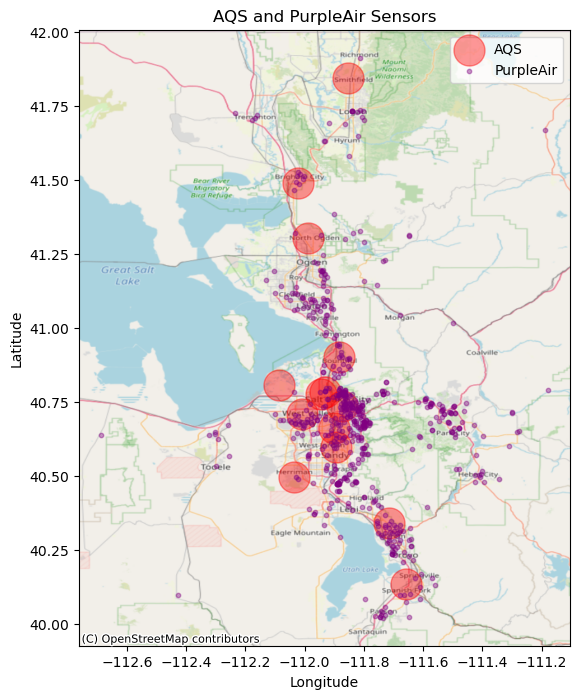

In [4]:
def display_points_on_map(df1, label1, df2, label2, title):
    """
    Display points from two dataframes on a static map using latitude and longitude.

    Parameters:
        df1 (DataFrame): First dataframe containing latitude and longitude columns. Make this AQS, markersize will be larger
        label1 (str): Friendly name of df1 for map legend
        df2 (DataFrame): Second dataframe containing latitude and longitude columns
        label2 (str): Friendly name of df2 for map legend
        title (str): Title for Map
    
    Returns:
        None
    """
    
    # Convert dataframes to GeoDataFrames
    gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.longitude, df1.latitude))
    gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude))

    # Set Coordinate Reference System (CRS) for GeoDataFrames
    gdf1.crs = 'EPSG:4326'  # WGS 84
    gdf2.crs = 'EPSG:4326'  # WGS 84

    # Plot points from df1
    ax = gdf1.plot(color='red', label=label1, markersize=500, alpha=0.4, figsize=(10, 8))

    # Plot points from df2
    gdf2.plot(ax=ax, color='purple', label=label2, markersize=10, alpha=0.4)

    # Add background map
    ctx.add_basemap(ax, crs=gdf1.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # Add legend
    plt.legend()

    # Set labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)

    # Show plot
    plt.show()

display_points_on_map(aqs_lat_long, "AQS", purple_air_lat_long, "PurpleAir", "AQS and PurpleAir Sensors")


# K-means

In [5]:
# give each sensor an arbitrary ID for clustering visual when combining dfs

def add_sensor_id_column(df, prefix):
    """
    Add an arbitrary "my_sensor_id" column with sequential values to the DataFrame.

    Parameters:
        df (DataFrame): DataFrame to which the column will be added.
        prefix (str): Prefix for the sensor IDs.

    Returns:
        DataFrame: df with the "my_sensor_id" column added.
    """
    # Make a copy of the DataFrame to avoid modifying the original DataFrame
    df = df.copy()
    
    # Generate sequential sensor IDs
    sensor_ids = [f"{prefix}{i+1}" for i in range(len(df))]

    # Add the "my_sensor_id" column to the DataFrame
    df.loc[:, 'my_sensor_id'] = sensor_ids
    
    return df

In [6]:
aqs_lat_long = add_sensor_id_column(aqs_lat_long, "AQS")
purple_air_lat_long = add_sensor_id_column(purple_air_lat_long, "PurpleAir")

In [7]:
# combine the dataframes into one for k-means clustering
aqs_purple_combined = pd.concat([aqs_lat_long, purple_air_lat_long])

In [8]:
# add a new 'source' column so we can visualize where sensor is from (possibly)

def determine_sensor_source(sensor_id):
    if 'AQS' in sensor_id:
        return 'AQS'
    elif 'PurpleAir' in sensor_id:
        return 'PurpleAir'
    else:
        return None

aqs_purple_combined['source'] = aqs_purple_combined['my_sensor_id'].apply(determine_sensor_source)

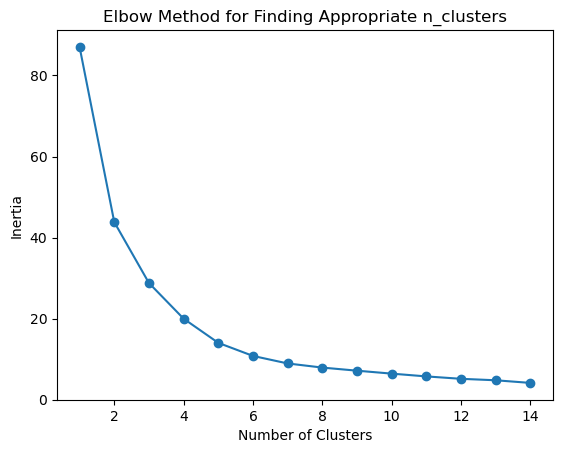

In [9]:
# Determine the number of clusters using elbow method

inertias = [] # intertia = within-cluster sum of squares against the number of clusters
for k in range(1, 15): # 1-14 for the number of AQS sensors
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(aqs_purple_combined[['latitude', 'longitude']])
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 15), inertias, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Finding Appropriate n_clusters')
plt.show()


/Users/jaredfeldman/miniforge3/envs/capstone/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


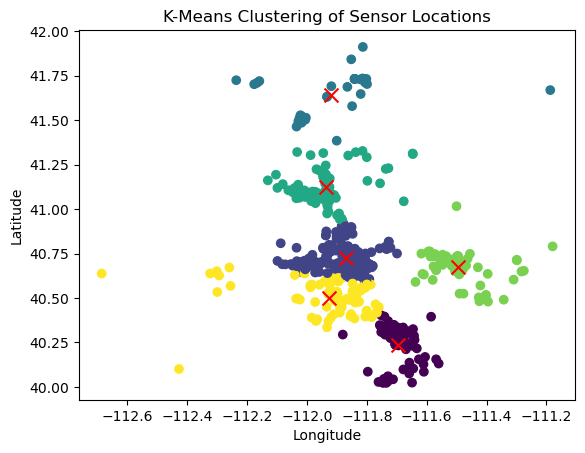

In [15]:
# Extract latitude and longitude columns
coordinates = aqs_purple_combined[['latitude', 'longitude']]

# Initialize the KMeans model
kmeans = KMeans(n_clusters=6)  # n_clusters determined visually from above

# Fit the model to the coordinates
kmeans.fit(coordinates)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Add cluster labels to the dataframe
aqs_purple_combined['cluster'] = kmeans.labels_

# Visualize the clusters
plt.scatter(aqs_purple_combined['longitude'], aqs_purple_combined['latitude'], c=aqs_purple_combined['cluster'], cmap='viridis')
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], marker='x', c='red', s=100)  # Plot cluster centers
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Sensor Locations')
plt.show()

# Print cluster centers
#print("Cluster Centers:")
#for i, center in enumerate(cluster_centers):
#    print(f"Cluster {i+1}: Latitude={center[0]}, Longitude={center[1]}")


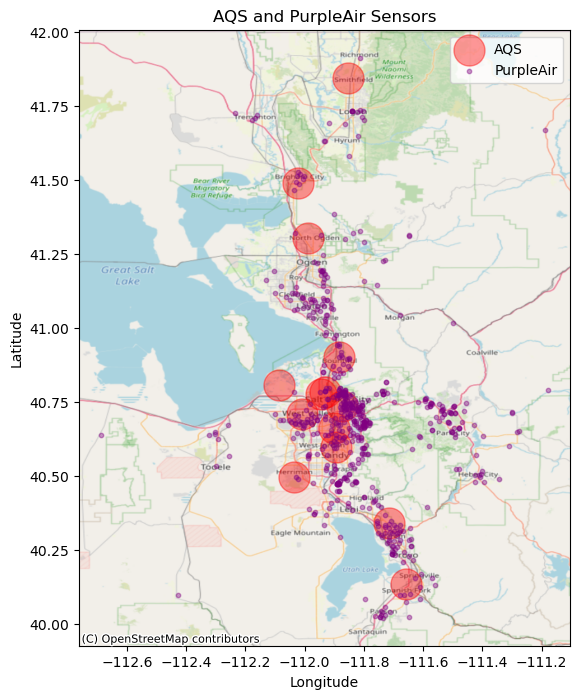

/Users/jaredfeldman/miniforge3/envs/capstone/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


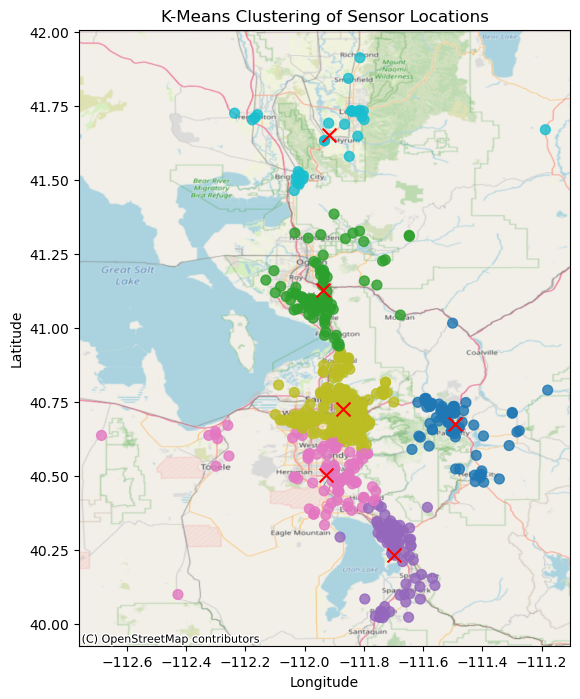

In [16]:
# Plot maps side-by-side to see where clusters fall and where sensors are

# Call the function to display AQS and PurpleAir sensors on the map
display_points_on_map(aqs_lat_long, "AQS", purple_air_lat_long, "PurpleAir", "AQS and PurpleAir Sensors")

# Extract latitude and longitude columns
coordinates = aqs_purple_combined[['latitude', 'longitude']]

# Initialize the KMeans model with desired number of clusters
kmeans = KMeans(n_clusters=6)  # determined visually from above

# Fit the model to the coordinates
kmeans.fit(coordinates)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Add cluster labels to the dataframe
aqs_purple_combined['cluster'] = kmeans.labels_

# Convert aqs_purple_combined to GeoDataFrame
gdf_combined = gpd.GeoDataFrame(aqs_purple_combined, geometry=gpd.points_from_xy(aqs_purple_combined.longitude, aqs_purple_combined.latitude))
gdf_combined.crs = 'EPSG:4326'

# Plot k-means clusters on the same map without color bar legend
fig, ax = plt.subplots(figsize=(10, 8))
gdf_combined.plot(ax=ax, column='cluster', cmap='tab10', markersize=50, legend=False, alpha=0.8)
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], marker='x', c='red', s=100)  # Plot cluster centers
ctx.add_basemap(ax, crs=gdf_combined.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Sensor Locations')
plt.show()
